In [140]:
import random
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import numpy as np
import pydot

from sklearn.externals.six import StringIO
from sklearn.tree import export_graphviz
from sklearn import preprocessing
from sklearn.metrics import cohen_kappa_score, make_scorer

MAX_FEATURES = 30


train_data = pd.read_csv('all_train_data_V6_pure_breed.csv')
test_data = pd.read_csv('all_test_data_V6_pure_breed.csv')

test_ids = test_data[['PetID']]

train_data.drop(train_data.select_dtypes(['object']), axis=1, inplace=True)
test_data.drop(test_data.select_dtypes(['object']), axis=1, inplace=True)


train_data = train_data.fillna(0) # too many pets with missing values (2/3 data)
test_data = test_data.fillna(0)  # fill missing values with 0

adoptionSpeed = train_data['AdoptionSpeed'] 
del train_data['AdoptionSpeed']

In [141]:
from sklearn.model_selection import train_test_split

# split the data set into train and test, test = 15% 
train, test, adoptionSpeed_train, adoptionSpeed_test = train_test_split(train_data, adoptionSpeed, test_size=0.2)
kappa_eval = make_scorer(cohen_kappa_score)

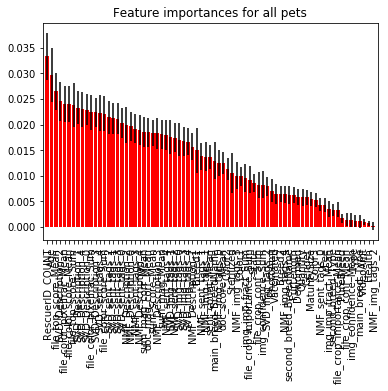

In [142]:
from sklearn.ensemble import RandomForestClassifier

# Feature importance based on a random forest
model = RandomForestClassifier(n_estimators=500, criterion='entropy') # n_estimators number of decision trees

# Train a random forest classifier for feature importance for all pets
model.fit(train, adoptionSpeed_train)

importances = model.feature_importances_
std = np.std([t.feature_importances_ for t in model.estimators_],
             axis=0)

index = np.argsort(importances)[::-1]    
labels = list(train.columns.values)
ordered_labels = [labels[i] for i in index]

# Plot the feature importances of the forest
fig, ax = plt.subplots()
fig.canvas.draw()
plt.title("Feature importances for all pets")
plt.bar(range(train.shape[1]), importances[index],
       color="r", yerr=std[index], align="center")
plt.xticks(range(train.shape[1]), index, rotation='vertical')
plt.xlim([-1, train.shape[1]])
ax.set_xticklabels(ordered_labels)
plt.show()

In [143]:
# Extract data sets with max_features most important features
feature_train = train.iloc[:, index[0]]
feature_test = test.iloc[:, index[0]]
feature_submission = test_data.iloc[:, index[0]]


for i in range(1, MAX_FEATURES):
    subset1 = train.iloc[ : ,index[i]]
    subset2 = test.iloc[ : ,index[i]]
    subset3 = test_data.iloc[:, index[i]]
    feature_train = pd.concat([feature_train, subset1], axis=1)
    feature_test = pd.concat([feature_test, subset2], axis=1)
    feature_submission = pd.concat([feature_submission, subset3], axis=1)

In [144]:
# Optimize the random forest to use later for voting

from sklearn.model_selection import GridSearchCV

parameters = {'max_depth':[2, 4, 6, 8], 'min_samples_split':[2, 10, 25, 50]}
gridsearch_forest = GridSearchCV(model, parameters, scoring = kappa_eval, cv=3)
gridsearch_forest.fit(train, adoptionSpeed_train)

# Gives the most optimal settings from the parameters space
best_parameters = gridsearch_forest.best_params_

# Retrain the model on best settings
rf_model = RandomForestClassifier(n_estimators=500, **best_parameters, criterion='entropy')
rf_model.fit(train_data, adoptionSpeed)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [145]:
import scipy as sp
from collections import Counter
from functools import partial
from math import sqrt

from sklearn.metrics import cohen_kappa_score, mean_squared_error
from sklearn.metrics import confusion_matrix as sk_cmatrix


# FROM: https://www.kaggle.com/myltykritik/simple-lgbm-image-features

# The following 3 functions have been taken from Ben Hamner's github repository
# https://github.com/benhamner/Metrics
def confusion_matrix(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Returns the confusion matrix between rater's ratings
    """
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(rater_a + rater_b)
    if max_rating is None:
        max_rating = max(rater_a + rater_b)
    num_ratings = int(max_rating - min_rating + 1)
    conf_mat = [[0 for i in range(num_ratings)]
                for j in range(num_ratings)]
    for a, b in zip(rater_a, rater_b):
        conf_mat[a - min_rating][b - min_rating] += 1
    return conf_mat

def histogram(ratings, min_rating=None, max_rating=None):
    """
    Returns the counts of each type of rating that a rater made
    """
    if min_rating is None:
        min_rating = min(ratings)
    if max_rating is None:
        max_rating = max(ratings)
    num_ratings = int(max_rating - min_rating + 1)
    hist_ratings = [0 for x in range(num_ratings)]
    for r in ratings:
        hist_ratings[r - min_rating] += 1
    return hist_ratings


def quadratic_weighted_kappa(y, y_pred):
    """
    Calculates the quadratic weighted kappa
    axquadratic_weighted_kappa calculates the quadratic weighted kappa
    value, which is a measure of inter-rater agreement between two raters
    that provide discrete numeric ratings.  Potential values range from -1
    (representing complete disagreement) to 1 (representing complete
    agreement).  A kappa value of 0 is expected if all agreement is due to
    chance.
    quadratic_weighted_kappa(rater_a, rater_b), where rater_a and rater_b
    each correspond to a list of integer ratings.  These lists must have the
    same length.
    The ratings should be integers, and it is assumed that they contain
    the complete range of possible ratings.
    quadratic_weighted_kappa(X, min_rating, max_rating), where min_rating
    is the minimum possible rating, and max_rating is the maximum possible
    rating
    """
    rater_a = y
    rater_b = y_pred
    min_rating=None
    max_rating=None
    rater_a = np.array(rater_a, dtype=int)
    rater_b = np.array(rater_b, dtype=int)
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(min(rater_a), min(rater_b))
    if max_rating is None:
        max_rating = max(max(rater_a), max(rater_b))
    conf_mat = confusion_matrix(rater_a, rater_b,
                                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0
    
    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            d = pow(i - j, 2.0) / pow(num_ratings - 1, 2.0)
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return (1.0 - numerator / denominator)


class OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4

        ll = quadratic_weighted_kappa(y, X_p)
        return -ll

    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        return X_p
    
    def coefficients(self):
        return self.coef_['x']
    
def rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))


In [146]:
import lightgbm as lgb


params = {'application': 'regression',
          'boosting': 'gbdt',
          'metric': 'rmse',
          'num_leaves': 70,
          'max_depth': 9,
          'learning_rate': 0.01,
          'bagging_fraction': 0.85,
          'feature_fraction': 0.8,
          'min_split_gain': 0.02,
          'min_child_samples': 150,
          'min_child_weight': 0.02,
          'lambda_l2': 0.0475,
          'verbosity': -1,
          'data_random_seed': 17}

# Additional parameters:
early_stop = 1000
verbose_eval = 100
num_rounds = 10000
n_splits = 5


from sklearn.model_selection import StratifiedKFold


kfold = StratifiedKFold(n_splits=n_splits, random_state=1337)


oof_train_lgb = np.zeros((train_data.shape[0]))
oof_test_lgb = np.zeros((test_data.shape[0], n_splits))
qwk_scores = []


i = 0

train_data['AdoptionSpeed'] = adoptionSpeed

for train_index, valid_index in kfold.split(train_data, train_data['AdoptionSpeed'].values):
    
    X_tr = train_data.iloc[train_index, :]
    X_val = train_data.iloc[valid_index, :]
    
    y_tr = X_tr['AdoptionSpeed'].values
    X_tr = X_tr.drop(['AdoptionSpeed'], axis=1)
    
    y_val = X_val['AdoptionSpeed'].values
    X_val = X_val.drop(['AdoptionSpeed'], axis=1)
    
    print('\ny_tr distribution: {}'.format(Counter(y_tr)))
    
    d_train = lgb.Dataset(X_tr, label=y_tr)
    d_valid = lgb.Dataset(X_val, label=y_val)
    watchlist = [d_train, d_valid]
    
    print('training LGB:')
    model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=verbose_eval,
                      early_stopping_rounds=early_stop)
    
    val_pred = model.predict(X_val, num_iteration=model.best_iteration)
    optR = OptimizedRounder()
    optR.fit(val_pred, y_val)
    coefficients = optR.coefficients()
    coefficients[0] = 1.645
    coefficients[1] = 2.115
    coefficients[3] = 2.84

    pred_val_y_k = optR.predict(val_pred, coefficients)
    print("Valid Counts = ", Counter(y_val))
    print("Predicted Counts = ", Counter(pred_val_y_k))
    #print("Coefficients = ", coefficients)
    qwk = quadratic_weighted_kappa(y_val, pred_val_y_k)
    qwk_scores.append(qwk)
    print("QWK = ", qwk)
    
    test_pred = model.predict(test_data, num_iteration=model.best_iteration)
    
    oof_train_lgb[valid_index] = val_pred
    oof_test_lgb[:, i] = test_pred
    
    i += 1
    
print('{} cv mean QWK score : {}'.format('LGBM', np.mean(qwk_scores)))
importance_type= "split" # "gain"
idx_sort = np.argsort(model.feature_importance(importance_type=importance_type))[::-1]
names_sorted = np.array(model.feature_name())[idx_sort]
imports_sorted = model.feature_importance(importance_type=importance_type)[idx_sort]

for n, im in zip(names_sorted, imports_sorted):
    print(n, im)


y_tr distribution: Counter({4: 3357, 2: 3229, 3: 2607, 1: 2472, 0: 328})
training LGB:
Training until validation scores don't improve for 1000 rounds.
[100]	training's rmse: 1.06126	valid_1's rmse: 1.09198
[200]	training's rmse: 1.0105	valid_1's rmse: 1.06793
[300]	training's rmse: 0.97858	valid_1's rmse: 1.05721
[400]	training's rmse: 0.956041	valid_1's rmse: 1.05184
[500]	training's rmse: 0.936388	valid_1's rmse: 1.04796
[600]	training's rmse: 0.919891	valid_1's rmse: 1.04487
[700]	training's rmse: 0.905496	valid_1's rmse: 1.0433
[800]	training's rmse: 0.892649	valid_1's rmse: 1.04208
[900]	training's rmse: 0.878571	valid_1's rmse: 1.04108
[1000]	training's rmse: 0.866097	valid_1's rmse: 1.04029
[1100]	training's rmse: 0.853652	valid_1's rmse: 1.0398
[1200]	training's rmse: 0.841998	valid_1's rmse: 1.03898
[1300]	training's rmse: 0.830161	valid_1's rmse: 1.03867
[1400]	training's rmse: 0.818135	valid_1's rmse: 1.0386
[1500]	training's rmse: 0.808175	valid_1's rmse: 1.03841
[1600]	tr

[1600]	training's rmse: 0.810205	valid_1's rmse: 1.02906
[1700]	training's rmse: 0.801423	valid_1's rmse: 1.02906
[1800]	training's rmse: 0.792429	valid_1's rmse: 1.02896
[1900]	training's rmse: 0.783741	valid_1's rmse: 1.02884
[2000]	training's rmse: 0.775041	valid_1's rmse: 1.02847
[2100]	training's rmse: 0.765235	valid_1's rmse: 1.02832
[2200]	training's rmse: 0.757583	valid_1's rmse: 1.02793
[2300]	training's rmse: 0.751392	valid_1's rmse: 1.028
[2400]	training's rmse: 0.745114	valid_1's rmse: 1.02783
[2500]	training's rmse: 0.738438	valid_1's rmse: 1.02772
[2600]	training's rmse: 0.730265	valid_1's rmse: 1.02776
[2700]	training's rmse: 0.722955	valid_1's rmse: 1.02779
[2800]	training's rmse: 0.71579	valid_1's rmse: 1.02779
[2900]	training's rmse: 0.708677	valid_1's rmse: 1.02781
[3000]	training's rmse: 0.701378	valid_1's rmse: 1.02795
[3100]	training's rmse: 0.695112	valid_1's rmse: 1.02797
[3200]	training's rmse: 0.688171	valid_1's rmse: 1.02837
[3300]	training's rmse: 0.681694	v

In [148]:
# Predict test 
optR = OptimizedRounder()
optR.fit(oof_train_lgb, train_data['AdoptionSpeed'].values)
coefficients = optR.coefficients()
coefficients[0] = 1.645
coefficients[1] = 2.115
coefficients[3] = 2.84



test_predictions_lgb = optR.predict(oof_test_lgb.mean(axis=1), coefficients)
del train_data['AdoptionSpeed']

# del feature_train['AdoptionSpeed']
'''
submission = pd.DataFrame({'PetID': test_ids['PetID'].values,
                           'AdoptionSpeed': test_predictions_lgb.astype(np.int32)})
submission.head()
submission.to_csv('submission.csv', index=False)
'''

"\nsubmission = pd.DataFrame({'PetID': test_ids['PetID'].values,\n                           'AdoptionSpeed': test_predictions_lgb.astype(np.int32)})\nsubmission.head()\nsubmission.to_csv('submission.csv', index=False)\n"

In [149]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from mlxtend.classifier import EnsembleVoteClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier

import xgboost as xgb
'''

agb_grid = {
              
              "base_estimator":[
                DecisionTreeClassifier(max_features = "auto", max_depth=3)],
              "n_estimators": [100, 200, 500],
              "learning_rate": [0.1, 0.08, 0.05, 0.03],
              "algorithm": ['SAMME.R', 'SAMME']
             }


ABC = AdaBoostClassifier()

# run grid search
agb_model = GridSearchCV(ABC, param_grid=agb_grid, scoring = kappa_eval, n_jobs=4, cv=3)

extra_model = ExtraTreesClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=3,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


# put the optimized random forest as base estimator
bagging_model = BaggingClassifier(rf_model, n_estimators = 1000,
                            max_samples=0.5, max_features=0.5)


xgb_model = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0, learning_rate=0.03, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=300,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)


mlp_grid = {'activation': ('identity', 'logistic', 'tanh', 'relu'), 
              'alpha':[0.0001, 0.001, 0.01],
              'learning_rate_init':[0.1, 0.5, 0.7]}

mlp_model = MLPClassifier(max_iter=200)
gridsearch_mlp = GridSearchCV(mlp_model, param_grid=mlp_grid, cv=3,scoring=kappa_eval)




classifiers = [
    ('rf', rf_model),
    ("mlp", xgb_model)
]

voting_model = VotingClassifier(estimators=classifiers, voting='soft')

voting_model.fit(feature_train, adoptionSpeed_train)

'''

'\n\nagb_grid = {\n              \n              "base_estimator":[\n                DecisionTreeClassifier(max_features = "auto", max_depth=3)],\n              "n_estimators": [100, 200, 500],\n              "learning_rate": [0.1, 0.08, 0.05, 0.03],\n              "algorithm": [\'SAMME.R\', \'SAMME\']\n             }\n\n\nABC = AdaBoostClassifier()\n\n# run grid search\nagb_model = GridSearchCV(ABC, param_grid=agb_grid, scoring = kappa_eval, n_jobs=4, cv=3)\n\nextra_model = ExtraTreesClassifier(bootstrap=True, class_weight=None, criterion=\'gini\',\n            max_depth=None, max_features=\'sqrt\', max_leaf_nodes=None,\n            min_impurity_decrease=0.0, min_impurity_split=None,\n            min_samples_leaf=2, min_samples_split=2,\n            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=3,\n            oob_score=False, random_state=None, verbose=0,\n            warm_start=False)\n\n\n# put the optimized random forest as base estimator\nbagging_model = BaggingClassifi

In [150]:
# MLP trained on feature data, random forest is trained on all data
# Combine MLP + Random Forest + light gbm
parameters = {'activation': ('identity', 'logistic', 'tanh', 'relu'), 
              'alpha':[0.0001, 0.001, 0.01],
              'learning_rate_init':[0.05, 0.1, 0.5, 0.7]}

mlp_model = MLPClassifier(max_iter=200)
gridsearch_mlp = GridSearchCV(mlp_model, parameters, cv=5)
gridsearch_mlp.fit(feature_train, adoptionSpeed_train)

# Gives the most optimal settings from the parameters space
best_parameters = gridsearch_mlp.best_params_

# Retrain the model on best settings
best_mlp = MLPClassifier(**best_parameters, max_iter=200)
best_mlp.fit(feature_train, adoptionSpeed_train)
# mlp_predicted = best_mlp.predict(feature_test)

MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.05, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [15]:
'''
voting_ans_pred = voting_model.predict(feature_test)
voting_ans_submiss = voting_model.predict(feature_submission)

kappa_voting = cohen_kappa_score(voting_ans_pred, adoptionSpeed_test)
print(kappa_voting)

'''

/home/mihaela/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.20700444029162357


/home/mihaela/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [ ]:
all_models = list()
all_models.append(rf_model)
all_models.append(best_mlp)

def combine_constructor(models, predict_data, ans=[]):
    """Based on a list of trained models
    """

    predictions = pd.DataFrame()
    kappa_scores = []
    index_model = 0


    for model in models:
        predictions[f"model_{index_model}"] = model.predict(predict_data)
        if len(ans) != 0:
            kappa_scores.append(cohen_kappa_score(
                predictions[f"model_{index_model}"], 
                ans
            ))
        index_model += 1

    return predictions, kappa_scores, index_model
      

In [165]:
rf_ans = rf_model.predict(test_data)
mlp_ans = best_mlp.predict(feature_submission)
lgb_ans = test_predictions_lgb.astype(np.int32)

In [166]:
submiss_pred = pd.DataFrame({'RF': rf_ans, 'MLP': mlp_ans, 'LGB': lgb_ans})

In [126]:
# helper function, takes a pandas data frame as returned by the combine constructor
def majority_vote(predictions):
    
    ans_voted = []
    for r in range(0, predictions.shape[0]):
        row = predictions.loc[r, :].values
        counts = np.bincount(row)
        ans_voted.append(np.argmax(counts))
        
    # ans_voted = ans_voted.astype(np.int32)
    return ans_voted


In [207]:
# Put priority on a certain prediction if that prediction is different from the majority vote
def priority_vote(predictions, index):
    
    # index is the (column) of the prefered vote from the predictions data frame
    ans_voted = []
    for r in range(0, predictions.shape[0]):
        row = predictions.loc[r, :].values
        counts = np.bincount(row)
        mode = np.argmax(counts)
        
        # if index is out of range will do majority_vote
        try: 
            priority = predictions[predictions.columns[index]][r]
            
            # if the prefered voter is different from the majority vote, 
            # prefer it
            
            if priority != mode:
                ans_voted.append(priority)
            else:
                ans_voted.append(mode)
        except IndexError:
            print("Index out of range. Will perform majority vote instead")
            major_vote = majority_vote(predictions)
            return major_vote
        
            
    return ans_voted


In [ ]:
# works best if predictions are not too dofferent between each other
import math
def weighted_vote(predictions, weights):
    
    ans_voted = []
    for r in range(0, predictions.shape[0]):
        row = predictions.loc[r, :].values
        average = 0
        
        for w in range(0, len(weights)):
            average += weights[w]*row[w]
        # round up
        average = math.ceil(average)
        ans_voted.append(average)
        
    return ans_voted
        

In [208]:
# final_ans = priority_vote(submiss_pred, 2)
final_ans = weighted_vote(submiss_pred, [0.25, 0.25, 0.5])

In [209]:
submission = pd.DataFrame({'PetID': test_ids['PetID'].values, 'AdoptionSpeed': final_ans})
submission.to_csv('submission-lgb-priority-vote.csv', index=False)
